torch.Size([60000, 28, 28])
torch.Size([60000])


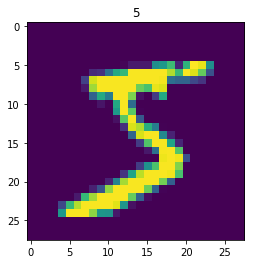

In [117]:
import torch
from torch.autograd import Variable
import torch.utils.data as Data
#pip --trusted-host pypi.python.org install torchvision  这样安装 ，使用pip install torchvision安装时一直失败，我也是醉了.....搞了半天...各种方法
#导入数据库
import torchvision
import torchvision.transforms as transforms  # transforms用于数据预处理
import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

BATCH_SIZE=50
IS_DOWNLOAD=True

train_data=torchvision.datasets.MNIST(
    root='./mnist/',#图片保存的位置
    train=True,#是否是训练数据
    transform=torchvision.transforms.ToTensor(),#转换
    download=IS_DOWNLOAD
)

print(train_data.train_data.shape)
print(train_data.train_labels.shape)

#可以指定颜色，如 cmap='gray'
#(28,28)
plt.imshow(train_data.train_data[0].numpy())
plt.title('%i' % train_data.train_labels[0])
plt.show()

#测试数据
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
# 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


# 为了节约时间, 我们测试时只测试前2000个
#test_data.test_data(10000x28x28)
#torch.unsqueeze(test_data.test_data, dim=1) 10000x1x28x28,（/255对数据进行归一化）
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
#:2000前2000的意思
test_y = test_data.test_labels[:2000]


    

In [118]:
#CNN模型  卷积(Conv2d) -> 激励函数(ReLU) -> 池化, 向下采样 (MaxPooling) -> 再来一遍 -> 展平多维的卷积成的特征图 -> 接入全连接层 (Linear) -> 输出

#Conv2d二维卷积层，stride: 控制相关系数的计算步长，
#in_channels(int) – 输入信号的通道，
#out_channels(int) – 卷积产生的通道
#kerner_size(int or tuple) - 卷积核的尺寸，
#stride(int or tuple, optional) - 卷积步长，
#padding(int or tuple, optional) - 输入的每一条边补充0的层数
#dilation(int or tuple, optional) – 卷积核元素之间的间距

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #输入（1，28，28）
        self.conv1=torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,   #输入
                out_channels=16,
                kernel_size=5, 
                stride=1,
                padding=2
                # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
            ),#输出（16,28,28）
            torch.nn.ReLU(),#激活函数
            torch.nn.MaxPool2d(kernel_size=2)   # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv2d(16,32,5,1,2),#output shape(32,14,14)
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),#output shape(32,7,7)
        )
        self.out=torch.nn.Linear(32*7*7,10)#全连接层，输出十个类别
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(x.size(0),-1) #展开多维度卷积成（batch_size,32*7*7）
        output=self.out(x)
        return output,x
    
    
    
cnn=CNN()
print(cnn)



CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)


Epoch:  1 | train loss: 2.3145 | test accuracy: 0.10
Epoch:  301 | train loss: 0.1805 | test accuracy: 0.93
Epoch:  601 | train loss: 0.2297 | test accuracy: 0.94
Epoch:  901 | train loss: 0.2056 | test accuracy: 0.92
Epoch:  1201 | train loss: 0.1698 | test accuracy: 0.94
Epoch:  1501 | train loss: 0.2026 | test accuracy: 0.92
Epoch:  1801 | train loss: 0.2616 | test accuracy: 0.93
Epoch:  2101 | train loss: 0.7213 | test accuracy: 0.91


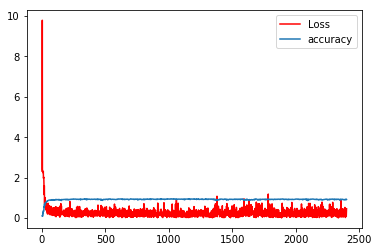

In [119]:
from sklearn.manifold import TSNE; HAS_SK = True
from matplotlib import cm

#训练
#优化器
optimizer=torch.optim.Adam(cnn.parameters(),lr=0.04)

#损失函数
loss_func=torch.nn.CrossEntropyLoss()


#训练测试
j=0
xx=[]
y_loss=[]
y_accuracy=[]
for i in range(2):
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x)
        b_y=Variable(y)
        j=j+1
        output=cnn(b_x)[0]
        #交叉熵损失
        loss=loss_func(output,b_y)
        #清除梯度
        optimizer.zero_grad()
        #反向传播，计算梯度
        loss.backward()
        #应用梯度变化后的数据
        optimizer.step()
        test_output,last_layer = cnn(test_x)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = sum(pred_y == test_y) / float(test_y.size(0))
        
        xx.append(j)
        y_loss.append(loss.data[0])
        y_accuracy.append(accuracy)
        if step % 300 == 0:
            print('Epoch: ', j, '| train loss: %.4f' % loss.data[0], '| test accuracy: %.2f' % accuracy)
            
plt.figure()
plt.plot(xx,y_loss,c='r',label='Loss')
plt.plot(xx,y_accuracy,label='accuracy')
plt.legend()
plt.show()

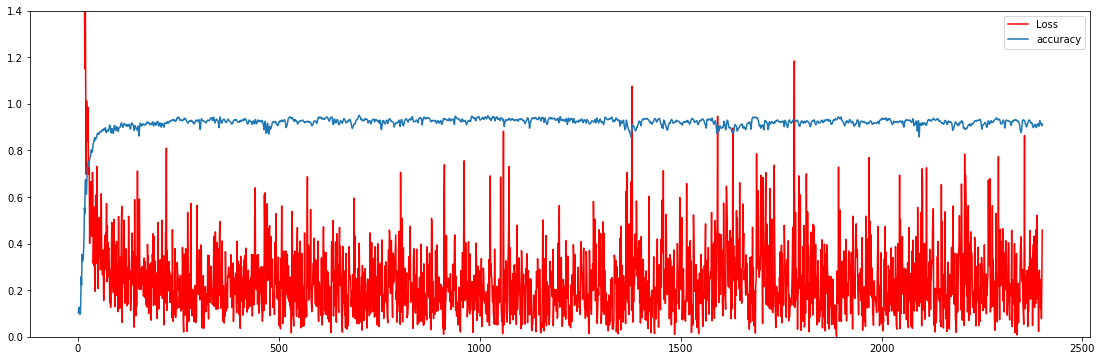

预测数： [7 2 1 0 4 1 4 4 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
真实数:  [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


In [130]:
plt.figure(figsize=(19,6))
plt.ylim(0,1.4)
plt.plot(xx,y_loss,c='r',label='Loss')
plt.plot(xx,y_accuracy,label='accuracy')
plt.legend()
plt.show()




test_output,_=cnn(test_x[:30])
pred_y = torch.max(test_output,1)[1].data.numpy().squeeze()

print('预测数：',pred_y)
print('真实数: ',test_y[:30].numpy())